In [1]:
import torch
import torchvision.transforms as tf
import os
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader


# ❶ 이미지의 전처리 과정
transforms = tf.Compose([
   tf.Resize(64),
   tf.CenterCrop(64),
   tf.ToTensor(),
   tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# ❷ ImageFolder()를 이용해 데이터셋을 작성
# root는 최상위 경로를, transform은 전처리를 의미합니다.
dataset = ImageFolder(
   root="/data",
   transform=transforms
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [2]:
import torch.nn as nn


class Generator(nn.Module):
   def __init__(self):
       super(Generator, self).__init__()
      
       # 생성자를 구성하는 층 정의
       self.gen = nn.Sequential(
           nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
           nn.BatchNorm2d(512),
           nn.ReLU(),

           nn.ConvTranspose2d(512, 256, kernel_size=4, 
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.ReLU(),

           nn.ConvTranspose2d(256, 128, kernel_size=4, 
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.ReLU(),

           nn.ConvTranspose2d(128, 64, kernel_size=4, 
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.ReLU(),

           nn.ConvTranspose2d(64, 3, kernel_size=4, 
                              stride=2, padding=1, bias=False),
           nn.Tanh()
       )

   def forward(self, x):
       return self.gen(x)

In [3]:
class Discriminator(nn.Module):
   def __init__(self):
       super(Discriminator, self).__init__()
      
       # 감별자를 구성하는 층의 정의
       self.disc = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.LeakyReLU(0.2),

           nn.Conv2d(64, 128, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.LeakyReLU(0.2),

           nn.Conv2d(128, 256, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.LeakyReLU(0.2),

           nn.Conv2d(256, 512, kernel_size=4, 
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(512),
           nn.LeakyReLU(0.2),

           nn.Conv2d(512, 1, kernel_size=4),
           nn.Sigmoid()
       )

   def forward(self, x):
       return self.disc(x)

In [4]:
def weights_init(m):
   # 층의 종류 추출
   classname = m.__class__.__name__
   if classname.find('Conv') != -1:
       # 합성곱층 초기화
       nn.init.normal_(m.weight.data, 0.0, 0.02)
   elif classname.find('BatchNorm') != -1:
       # 배치정규화층 초기화
       nn.init.normal_(m.weight.data, 1.0, 0.02)
       nn.init.constant_(m.bias.data, 0)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPUs 2 and 3 to use

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

# 생성자 정의
G = Generator().to(device)
# ❶ 생성자 가중치 초기화
G.apply(weights_init)

# 감별자 정의
D = Discriminator().to(device)
# ❷ 감별자 가중치 초기화
D.apply(weights_init)

import tqdm

from torch.optim.adam import Adam

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [6]:
for epochs in range(200):
   iterator = tqdm.tqdm(enumerate(loader, 0), total=len(loader))

   for i, data in iterator:
       D_optim.zero_grad()
      
       # ➊ 실제 이미지에는 1, 생성된 이미지는 0으로 정답을 설정
       label = torch.ones_like(
           data[1], dtype=torch.float32).to(device)
       label_fake = torch.zeros_like(
           data[1], dtype=torch.float32).to(device)
      
       # ➋ 실제 이미지를 감별자에 입력
       real = D(data[0].to(device))
      
       # ❸ 실제 이미지에 대한 감별자의 오차를 계산
       Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
       Dloss_real.backward()
       
       # ➊ 가짜 이미지 생성
       noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
       fake = G(noise)
      
       # 가짜 이미지를 감별자에 입력
       output = D(fake.detach())
      
       # 가짜 이미지에 대한 감별자의 오차를 계산
       Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
       Dloss_fake.backward()
      
       # ➋ 감별자의 전체 오차를 학습
       Dloss = Dloss_real + Dloss_fake
       D_optim.step()
       
       # ➊ 생성자의 학습
       G_optim.zero_grad()
       output = D(fake)
       Gloss = nn.BCELoss()(torch.squeeze(output), label)
       Gloss.backward()

       G_optim.step()

       iterator.set_description(f"epoch:{epochs} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

torch.save(G.state_dict(), "Generator.pth")
torch.save(D.state_dict(), "Discriminator.pth")

epoch:0 iteration:147 D_loss:0.022818420082330704 G_loss:8.256084442138672: 100%|██████████| 148/148 [00:54<00:00,  2.70it/s]
epoch:1 iteration:147 D_loss:0.014450350776314735 G_loss:7.9222259521484375: 100%|██████████| 148/148 [00:47<00:00,  3.09it/s]
epoch:2 iteration:147 D_loss:0.006468300707638264 G_loss:7.209883213043213: 100%|██████████| 148/148 [00:47<00:00,  3.12it/s]  
epoch:3 iteration:147 D_loss:0.05342041328549385 G_loss:5.800118923187256: 100%|██████████| 148/148 [00:48<00:00,  3.08it/s]   
epoch:4 iteration:147 D_loss:0.162471741437912 G_loss:4.639860153198242: 100%|██████████| 148/148 [00:47<00:00,  3.10it/s]   
epoch:5 iteration:147 D_loss:0.17653809487819672 G_loss:5.372972011566162: 100%|██████████| 148/148 [00:48<00:00,  3.05it/s]  
epoch:6 iteration:147 D_loss:0.13653674721717834 G_loss:6.329629421234131: 100%|██████████| 148/148 [00:48<00:00,  3.06it/s]  
epoch:7 iteration:147 D_loss:2.4215991497039795 G_loss:8.58993148803711: 100%|██████████| 148/148 [00:47<00:00,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9999996].


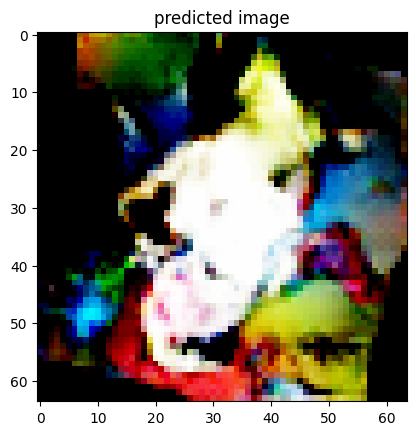

In [9]:
import matplotlib.pyplot as plt

with torch.no_grad():
   G.load_state_dict(
       torch.load("./Generator.pth", map_location=device))

   # 특징 공간 상의 랜덤한 하나의 점을 지정
   feature_vector = torch.randn(1, 100, 1, 1).to(device)
   # 이미지 생성
   pred = G(feature_vector).squeeze()
   pred = pred.permute(1, 2, 0).cpu().numpy()

   plt.imshow(pred)
   plt.title("predicted image")
   plt.show()

In [12]:
import os
os.makedirs("/app", exist_ok=True)

torch.save(G.state_dict(), "/app/Generator.pth")
torch.save(D.state_dict(), "/app/Discriminator.pth")